# CMA/ES Sigma Baseline, 1th try: fixed cov, lapse + sigma_base, sum LL

Changed so that sigma_baseline is added at the end.

Replaces sigma output!

Retry full CMA/ES sweep, fixed covariance of recall, still keep lapse rate. Trying LL because I don't like how much LL90 let's the model get away with...

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

## Reload data

In [6]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_ll_1try_Mratiosigmaxsigmabaselinelapserate_repetitions5_080816
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-ad4352f9-feb4-41e0-8ab6-230f07b9c5da.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_ll_1try_Mratiosigmaxsigmabaselinelapserate_repetitions5_080816


In [7]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [8]:
parameter_names_sorted

['ratio_conj', 'M', 'sigmax', 'lapse_rate', 'sigma_baseline']

In [11]:
df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)),
                             ('ratio_conj', candidates_parameters[:, 0]),
                             ('M', candidates_parameters[:, 1]),
                             ('sigmax', candidates_parameters[:, 2]),
                             ('lapse_rate', candidates_parameters[:, 3]),
                             ('sigma_baseline', candidates_parameters[:, 4]),
                             ('dist_nll90', np.ma.masked_greater(fitness.flatten(), 1e8)),
                            ])

In [12]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000

df_best_fits = df_all_fits[df_all_fits.dist_nll90 < LL_max_cutoff]

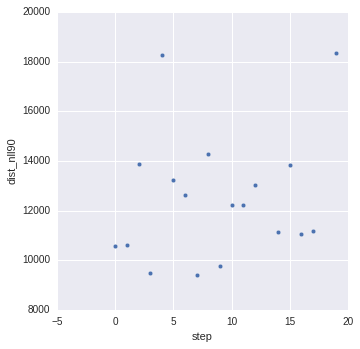

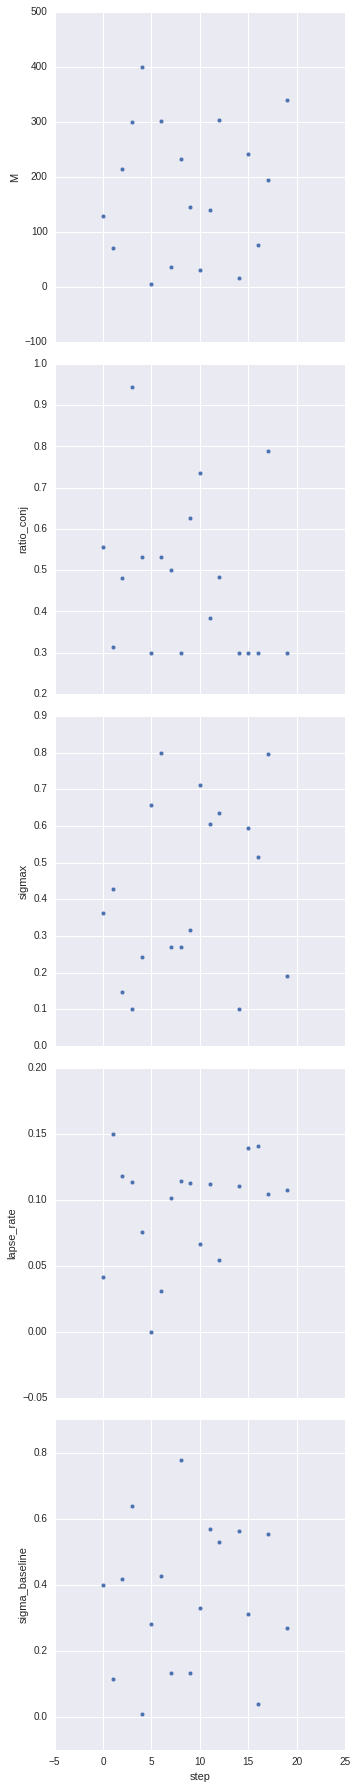

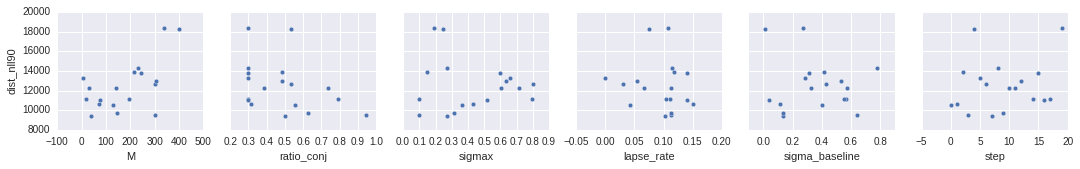

In [20]:
# Learning curve
sns.pairplot(df_best_fits,
             y_vars=['dist_nll90'],
             x_vars=['step'],
             size=5
            )

# Check training of parameters
sns.pairplot(df_best_fits,
             y_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate', 'sigma_baseline'],
             x_vars=['step'],
             size=5
            )

# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate', 'sigma_baseline', 'step'],
             y_vars=['dist_nll90'],
            )



## Check parameters values obtained

In [21]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).iloc[0]
df_bestparams

step                 19.000000
ratio_conj            0.300000
M                   340.075103
sigmax                0.190233
lapse_rate            0.107492
sigma_baseline        0.268753
dist_nll90        18350.408140
Name: 19, dtype: float64

In [94]:
%env WORKDIR_DROP

'/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory'

In [100]:
%run /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/experimentlauncher.py \
--action_to_do launcher_do_fitexperiment_allmetrics --inference_method none  --num_samples 200  --renormalize_sigmax \
--autoset_parameters --code_type mixed  --sigmay 0.00001  --experiment_id bays09 \
--lapse_rate {df_bestparams['lapse_rate']} --M {int(df_bestparams['M'])} --sigmax {df_bestparams['sigmax']} \
--ratio_conj {df_bestparams['ratio_conj']} --sigma_output {df_bestparams['sigma_output']} \
--filter_datapoints_size 1500 --filter_datapoints_selection 'random'

Arguments: ['--action_to_do', 'launcher_do_fitexperiment_allmetrics', '--inference_method', 'none', '--num_samples', '200', '--renormalize_sigmax', '--autoset_parameters', '--code_type', 'mixed', '--sigmay', '0.00001', '--experiment_id', 'bays09', '--lapse_rate', '0.0449174690251', '--M', '130', '--sigmax', '0.1', '--ratio_conj', '0.667979015165', '--sigma_output', '0.27905831348', '--filter_datapoints_size', '1500', '--filter_datapoints_selection', 'random']

        Given a single experiment_id, will run the model on all T in the experimental data.
        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperimentsinglet
{'M_layer_one': 400, 'action_to_do': 'launcher_do_fitexperiment_allmetrics', 'code_type': 'mixed', 'renormalize_sig

In [101]:
plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)

Doing Paper plots for bays09. 
Fig5 1, Fig6 1, Fig13 1


DATA T 1
DATA T 2
mu: 1.082, kappa: 0.049
{'R': 36.81578133480852, 'u': 0.63105830512728389, 'pvalue': 0.26400120106126324, 'V': 17.282243440959572}
DATA T 4
mu: -0.002, kappa: 0.099
{'R': 222.82053476246375, 'u': 4.6974584915402646, 'pvalue': 1.3170934763939712e-06, 'V': 222.82002071049047}
DATA T 6
mu: 0.079, kappa: 0.117
{'R': 438.12787929238908, 'u': 7.1325356723057141, 'pvalue': 4.9271697832864447e-13, 'V': 436.77682423369907}


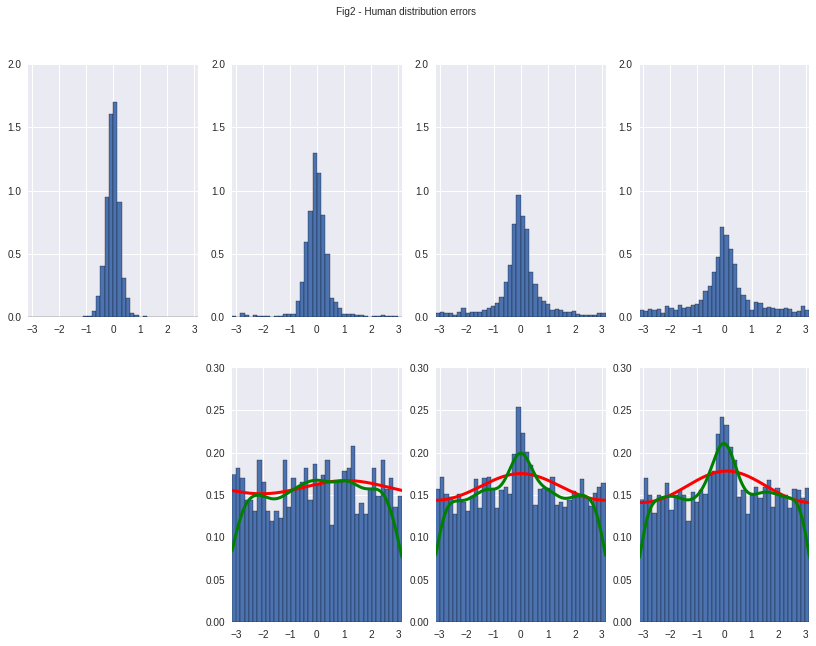

In [ ]:
axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

MODEL T 1
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -439.74
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 08.08 16:50                                                     
Loglikelihood: -438.01
top 90% loglike: -6.24
MODEL T 2
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -603.09
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 08.08 16:51                                                     
Loglikelihood: -531.37
top 90% loglike: -92.15
mu: 0.134, kappa: 0.000
{'R': 56.260895842662812, 'u': -0.83396365170504849, 'pvalue': 0.79784926659873245, 'V': -22.839035208911838}
MODEL T 4
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -853.15
--> Pass 1
Sampling theta: 200 samples, 100 burnin, select last
100.00%, -- - 08.08 16:53                                                     
Loglikelihood: -754.35
top 90% loglike: -303.74
mu: 0.092, kappa: 0.091
{'

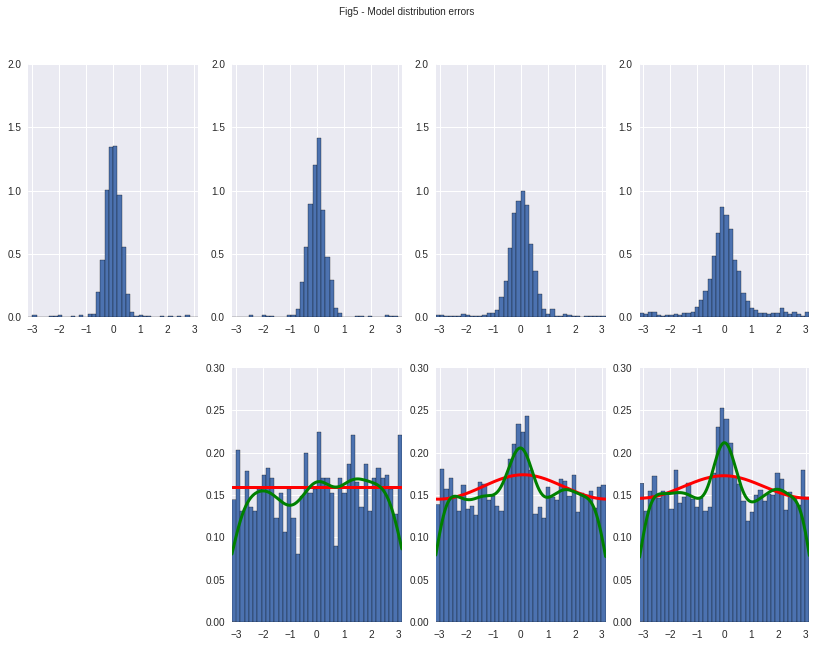

In [105]:
axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

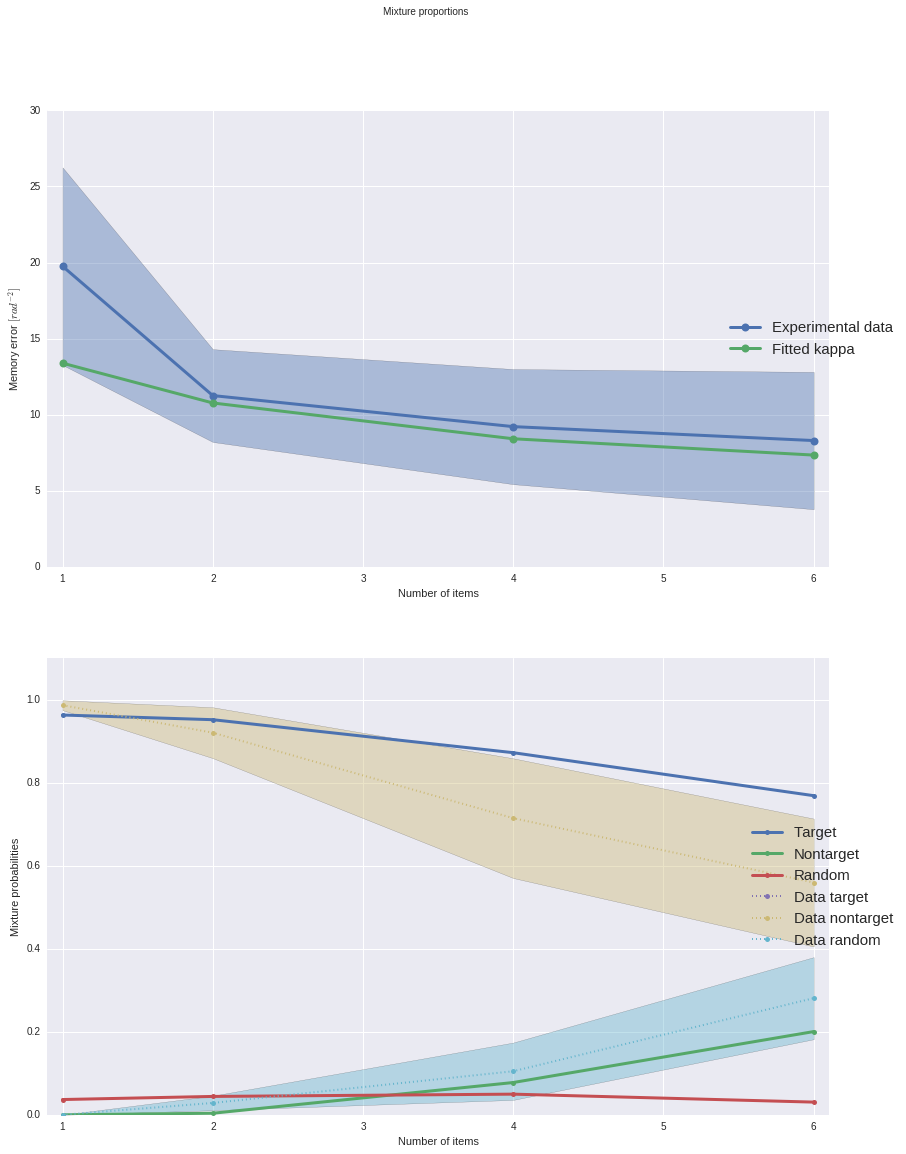

In [106]:
axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13()